In [41]:
import numpy as np
import os
import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotting as pt
import scipy

In [3]:
os.chdir('/Users/cwagner2/Work/projects/malaria/pf-longitudinal-antigens/immunity-sims/pf-tent/') 

In [5]:
def simulate_bites(y,eir):
    '''
    Produces a vector with bite times up until year, y, is reached.

    Time between bites pulled from exponential distribution wih mean rate of k = eir/365.
    '''
    k = eir/365
    n = round(y*eir*2)
    spaces = st.expon.rvs(scale=(1/k), loc=0, size=n)
    times = np.cumsum(spaces)
    trimmed = times[times <= y*365]
    bites = np.ceil(trimmed).astype(int)
    return bites

def simulate_genotypes(n,a,power):
    '''
    n = number of strains to simulate
    a = vector whose length corresponds to number of loci.
    Each entry corresponds to the number of alleles at that loci.
    so a = [3,4,6] will simulate a strain with 3 loci. The first
    loci has 3 alleles; the second loci has 4 alleles, and the third
    loci has 6 alleles.

    Returns genotype as a L x n matrix, where L = the number of loci.
    '''
    length = len(a)
    M = np.empty((length,n),dtype=int)
    floats = np.random.power(power,(length,n))
    genotype = np.ceil(floats*np.repeat(a,n).reshape(length,n))-1
    M[:] = genotype
    return M

def get_mz(size,meroz,mshape):
    '''
    Generates starting number of merozoites from a lognormal distribution.
    Values from here: https://www.science.org/doi/10.1126/scitranslmed.aag2490
    '''
    mz = st.lognorm.rvs(s=mshape,scale=meroz,size=size)
    return mz

def get_r(size,growthrate,rscale):
    '''
    Generates r from normal distribution.
    Values from here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7198127/
    '''
    r = st.norm.rvs(loc = growthrate, scale=rscale,size=size)
    return r

def simulate_params(n,meroz,growthrate,mshape,rscale):
    '''
    Simulates mz and growth rate for strains.
    Returns 2 x n matrix.

    Inputs:
        n = number of strains
        meroz = average starting number of merozites
        growthrate = average starting growthrate
    '''
    M = np.zeros((2,n))
    M[0,:] = get_mz(n,meroz,mshape)
    M[1,:] = get_r(n,growthrate,rscale)
    return M

def simulate_immune_effect(mean, alpha, a):
    '''
    Returns immune loci by allele matrix with immune effect upon exposure.
    '''
    n_loci = len(a)
    n_alleles = max(a)
    beta = (alpha*(1-mean))/mean
    effect = np.random.beta(alpha,beta,(n_loci,n_alleles))
    return effect

def create_allele_matrix(a,y):
    '''
    Creates matrix to track parasitemia.
    '''
    length = len(a)
    width = max(a)
    days = 365*y
    M = np.zeros((length,width,days))
    return M

def create_strain_matrix(n,y):
    '''
    Creates n x y*365 matrix to track strains presence per day.
    '''
    M = np.zeros((n,y*365))
    return M

def add_infection(t,j,mz,gtype,sM,pM):
    '''
    Adds infection to strain & parasite matrices.

    Inputs:
        t = time in days
        j = bite number
        mz = start of merozites
        gtype = genotype of infection
        sM = matrix tracking parasitemia by strain
        pM = matrix tracking parasitemia by allele
    '''
    sM[j,t] = mz
    n_loci = len(gtype)
    pM[np.arange(n_loci),(gtype),t] += mz

def update_immunity(t,pM,iM,gamma,immunity):
    '''
    Immunity exponentially decays if parasite not present.

    Inputs:
        t = time in days
        locus = locus number
        allele = allele number
        pM = matrix tracking parasitemia by allele
        iM = matarix tracking immunity by allele
        tHalf = half-life of immunity
    '''
    if t >= 14:
        iM[:,:,t] = iM[:,:,t-1]*np.exp(-gamma)
        iM[:,:,t][pM[:,:,t-14]>0] = np.minimum(iM[:,:,t-1][pM[:,:,t-14]>0] + immunity[pM[:,:,t-14]>0], 1)


def get_strain_immunity(gtype,i2,w,rows):
    '''
    Returns immunity to strain.
    gtype = genotype of strain
    i2 = immune matrix at t of interest.
    w = vector weighting immunity by allele
    '''
    crossed = i2[rows,gtype]
    imm = (crossed*np.asarray(w)).sum(axis=1)
    return imm

def modulate_growth_rate(imm,r0,rend,xh, b):
    '''
    Modulates growth rate based on immunity.
    rend = final growth rate at full immunity
    xh = inflection point for % immunity change
    b = intensity of immune effect
    '''
    c = np.tan(np.pi/2*xh)**b
    r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend
    return r

def get_parasitemia(p0,r,k,pgone):
    '''
    Returns parasitemia given growth rate & carrying capacity.
    '''
    rpos = k/(1+((k-p0)/p0)*np.exp(-r))
    rneg = p0*np.exp(r)
    p = rneg
    p[r>0] = rpos[r>0]
    p[p<pgone]= 0
    return p

def update_parasitemia(t,active,w,gM,iM,rV,sM,pM,k,rend,xh,b,pgone):
    '''
    Updates parasitemia for each strain and allele by bite number.

    Inputs:
        t = time in days
        j = bite number
        w = vector weighting immunity by allele
        gM = genotype matrix
        iM = immune matrix
        rV = vector tracking initial growth rate by bite number.
        sM = matrix tracking parasitemia by strain
        pM = matrix tracking parasitemia by allele
        k = carrying capacity
        rend = growth rate with 100% immunity
        xh = param scaling immunity's impact on growth rate
        b = param scaling immunity's impact on growth rate
        pgone = threshold below which infection goes to zero
    '''
    active = np.asarray(list(active),dtype=int)
    gtype = gM[:,active].T
    n_strains,n_loci = gtype.shape
    rows = np.broadcast_to(np.arange(n_loci),(n_strains,n_loci))
    imm = get_strain_immunity(gtype,iM[:,:,t-1],w,rows)
    r = modulate_growth_rate(imm,rV[active],rend,xh,b)

    p0 = sM[active,t-1]
    p = get_parasitemia(p0,r,k=k,pgone=pgone)
    sM[active,t] = p
    loci,alleles = iM[:,:,t].shape
    zeroth = np.zeros((n_loci,alleles,n_strains))

    strained = np.broadcast_to(np.arange(n_strains),(n_loci,n_strains)).T
    zeroth[rows,gtype,strained] = np.broadcast_to(p,(n_loci,n_strains)).T
    psum = np.sum(zeroth,axis=2)
    pM[:,:,t] = psum
    done = set(active[p==0])
    return done

def get_fever_threshold(arr,t):
    '''
    Returns fever threshold at t
    '''
    thresh = arr[arr[:,0]>=(t/365),1][0]
    return thresh

def treat_malaria(t, threshhold, pM, sM, m,a):
    '''
    Treat if parasitemia goes above certain threshold. Modifies parasite density
    matrix & strain matrix. Returns updated list with days malaria has occured.
        threshold = threshold for treatment
        pM = matrix tracking parasite density by allele across time.
        sM = matrix tracking parasitemia by strain across time.
        m = list with days malaria has occured
    '''
    if pM[0,:,t-1].sum(axis=0) > threshhold:
        pM[:,:,t] = 0
        sM[:,t] = 0
        m.append(t-1)
        a = set()
    return m,a

def load_data():
    '''
    Loads data used in the model
    '''
    fever = np.load("data/fever.npy")
    breaks = np.load("data/breaks.npy")
    return fever, breaks

def get_fever_arr(eir,fever,breaks):
    '''
    Returns 40 x 2 array, where column 0 is age cutoffs, and column 1 is parasite density
    for fever threshold at that age.
    '''
    eir_loc = (breaks[:,2]>=eir).nonzero()[0][0]
    age_index,pardens_index = (fever[:,:,eir_loc]).nonzero()
    age_breaks, age_loc = np.unique(age_index,return_index=True)
    pdens = breaks[pardens_index[age_loc],1]
    age = breaks[age_breaks,0]
    arr = np.stack((age,10**pdens),axis=1)
    return arr

def simulate_person(y,eir,a,w,fever_arr,meroz=0.8,growthrate=0.8,mshape=1,rscale=0.4,tHalf=300,rend=-0.05,xh=0.5,b=-1,k=10**6,pgone=0.001,power=1.3,iEffect=0.05,iSkew=2):
    '''
    Runs simulation for one person. Returns matrix tracking parasitemia by allele,
    matrix tracking immunity by allele, matrix tracking parasitemia by strain, and
    a list containing the days of every malaria episode someone had.

    Inputs:
        y = years to simulate
        eir = entomological inoculation rate
        a = vector with number of allels per loci
        meroz = average starting number of merozites
        growthrate = average starting growthrate
        w = vector weighting immunity by allele
        k = carrying capacity
        rend = growth rate at 100% immmunity
        xh = param scaling immunity's impact on growth rate
        b = param scaling immunity's impact on growth rate
        pgone = threshold below which infection goes to zero
    '''
    # Simulates bites & strain characteristics
    bites = simulate_bites(y,eir)
    n = len(bites)
    gtypes = simulate_genotypes(n,a,power)
    params = simulate_params(n,meroz,growthrate,mshape=mshape,rscale=rscale)
    gamma = 0.693/tHalf
    immunity = simulate_immune_effect(iEffect,iSkew,a)

    # Creates objects to record
    pM = create_allele_matrix(a,y)
    iM = create_allele_matrix(a,y)
    sM = create_strain_matrix(n,y)
    malaria = []
    active = set()

    # Runs forward time simulation
    ## Day 0:
    t = 0
    if t in bites: # Case where first bite is on day zero.
        locs = np.where(bites == t)
        for j in locs[0]:
            add_infection(t,j,params[0,j],gtypes[:,j],sM,pM)
            active.add(j)

    ## Day 1+
    for t in np.arange(1,y*365):
        if active:
            drop = update_parasitemia(t=t,active=active,w=w,gM=gtypes,iM=iM,rV=params[1,:],sM=sM,pM=pM,k=k,rend=rend,xh=xh,b=b,pgone=pgone)
            if drop:
                active = active.difference(drop)
        if t in bites:
            if not len(malaria) > 0 or t - malaria[-1] > 14:
                locs = np.where(bites == t)
                for j in locs[0]:
                    add_infection(t,j,params[0,j],gtypes[:,j],sM,pM)
                    active.add(j)
        thresh = get_fever_threshold(fever_arr, t)
        malaria,active = treat_malaria(t,thresh,pM,sM,malaria,active)
        update_immunity(t=t,pM=pM,iM=iM,gamma=gamma,immunity=immunity)
    return pM, iM, sM, malaria

def simulate_cohort(n_people,y,eir,a,w,meroz=0.8,growthrate=0.8,mshape=1,rscale=0.4,tHalf=300,rend=-0.05,xh=0.5,b=-1,k=10**6,pgone=0.001,power=1.3,iEffect=0.05,iSkew=2,limm=0.6):
    '''
    Simulates an entire cohort of individuals.

    Returns n_people x loci x alleles x t matrices tracking parasite density & immunity at each allele.
    Returns dictionary containing strain matrices for each person.
    Returns dictionary containing lists of malaria episodes for each person.
    Returns dictionary containing infection matrices for each person.

    Input:
        y = years to simulate
        a = vector of len(loci) specifying number of alleles at each locus
        w = immune weighting for each locus
        delta = immunity waning rate
    '''
    # Create objects to record
    all_parasites = np.zeros((n_people, len(a), max(a), y*365))
    all_immunity = np.zeros((n_people, len(a), max(a), y*365))
    all_strains = {}
    all_malaria = {}

    # Load dataset for fever threshhold
    fever, breaks = load_data()
    fever_arr = get_fever_arr(eir,fever,breaks)

    adjeir = limm*eir

    # Simulate people
    for person in range(n_people):
        pmatrix, imatrix, smatrix, malaria = simulate_person(y,adjeir,a,w,fever_arr,meroz=meroz,growthrate=growthrate,mshape=mshape,rscale=rscale,tHalf=tHalf,rend=rend,xh=xh,b=b,k=k,pgone=pgone,power=power,iEffect=iEffect, iSkew=iSkew)
        all_parasites[person,:,:,:] = pmatrix
        all_immunity[person,:,:,:] = imatrix
        all_strains[person] = smatrix
        all_malaria[person] = malaria

    return all_parasites, all_immunity, all_strains, all_malaria


In [63]:
y = 5
a = np.repeat(10,5)
w = np.repeat(1/5, 5)
fever,breaks = load_data()
fever_arr = get_fever_arr(eir,fever,breaks)
n_people=100
n_outcomes = 15 + (5*y)
eir=40

In [7]:
%load_ext line_profiler

In [10]:
%lprun -f simulate_person simulate_person(y,eir,a,w,fever_arr)

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_7370/1659544076.py:143: RuntimeWarning: divide by zero encountered in reciprocal
  r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend


Timer unit: 1e-09 s

Total time: 0.140686 s
File: /var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_7370/1659544076.py
Function: simulate_person at line 240

Line #      Hits         Time  Per Hit   % Time  Line Contents
   240                                           def simulate_person(y,eir,a,w,fever_arr,meroz=0.8,growthrate=0.8,mshape=1,rscale=0.4,tHalf=300,rend=-0.05,xh=0.5,b=-1,k=10**6,pgone=0.001,power=1.3,iEffect=0.05,iSkew=2):
   241                                               '''
   242                                               Runs simulation for one person. Returns matrix tracking parasitemia by allele,
   243                                               matrix tracking immunity by allele, matrix tracking parasitemia by strain, and
   244                                               a list containing the days of every malaria episode someone had.
   245                                           
   246                                               Inputs:


In [9]:
pmatrix,imatrix,smatrix,malaria= simulate_person(y,eir,a,w,fever_arr)

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_7370/1659544076.py:143: RuntimeWarning: divide by zero encountered in reciprocal
  r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend


In [75]:
def create_weight_alleles(loci, alleles):
    '''
    Returns weight & allele vectors.
    '''
    starter = np.ones(int(loci))
    a = alleles * starter
    a = a.astype(int)
    w = starter * (1/loci)
    return a, w

def get_visits(malaria,period,y):
    '''
    Returns passive & active visit dates in a list.
    '''
    start = np.random.randint(1,period)
    if len(malaria):
        if start > malaria[0]:
            start = malaria[0]
    active = np.arange(start,y*365,period,dtype=int)
    malaria = np.asarray(malaria,dtype=int)
    visits = np.union1d(active,malaria)
    return visits

def get_Parasitemia(pmatrix,visits):
    '''
    Returns prevalence & parasite density (if parasites) for every visit.
    Parasite density does not include Zeros.
    '''
    results = pmatrix[0,:,visits].sum(axis=1)
    pdens = results[results != 0]
    prev = np.count_nonzero(results)/len(results)
    return pdens, prev

def get_asymps(pmatrix,visits,malaria):
    '''
    Returns day of first asymptomatic parasitemia
    '''
    pdens = pmatrix[0,:,visits].sum(axis=1)
    locs = np.flatnonzero(pdens)
    pos = visits[locs]
    asymps = np.setdiff1d(pos, malaria)
    return asymps

def get_spacing(asymps, malaria):
    '''
    Returns time window between first asymptomatic case & last symptomatic case
    '''
    diff = malaria[-1] - asymps[0]
    spacing = max(diff,0)
    return spacing

def get_intermediate_density(visits,asymps, malaria, pmatrix):
    '''
    Returns mean measured parasite density during inbetween period. This mean does include zero values.
    Also returns % lamp only & % microscopy only. Sets microscopy cutoff at 90.
    '''
    between = visits[(visits >= asymps[0]) & (visits <= malaria[-1])]
    pdens = pmatrix[0,:,between].sum(axis=1)
    lamp = len(pdens[pdens>1])/len(pdens)
    micro = len(pdens[pdens>90])/len(pdens)
    mean = np.nanmean(pdens)
    return mean,lamp,micro

def get_yearly_cases(malaria,y):
    '''
    Returns number of cases for each year.
    '''
    starts = 365*np.arange(y)
    ends = 365*np.arange(1,y+1)
    malaria = np.asarray(malaria)
    cases = [len(malaria[(malaria < end) & (malaria>=start)]) for start,end in zip(starts,ends)]
    return cases

def get_yearly_prevs(y,visits,pmatrix):
    '''
    Returns number of cases for each year.
    '''
    starts = 365*np.arange(y)
    ends = 365*np.arange(1,y+1)
    times = [visits[(visits < end) & (visits>=start)] for start,end in zip(starts,ends)]
    n_visits = np.asarray([len(time) for time in times])
    pdens = [pmatrix[0,:,check].sum(axis=1) for check in times]
    micros = [len(pden[pden>90]) for pden in pdens]
    lamps = [len(pden[pden>1]) for pden in pdens]
    micro = np.asarray(micros)/n_visits
    lamp = np.asarray(lamps)/n_visits
    onlypos = [pden[pden!=0] for pden in pdens]
    pos = [len(pden) for pden in onlypos]
    meanpos = [np.nanmean(pden) for pden in onlypos]
    return micro,lamp,pos, meanpos

def get_symps(cases,pos):
    symps = np.asarray(cases)/np.asarray(pos)
    return symps

def run_outcomes(all_parasites,all_strains,all_malaria,y,n_people,n_outcomes):
    outcomes = np.empty((n_outcomes,n_people))
    for person in range(n_people):
        pmatrix = all_parasites[person,...]
        smatrix = all_strains[person]
        malaria = all_malaria[person]
        visits = get_visits(malaria,30,y)

        Parasitemia, perPositivity = get_Parasitemia(pmatrix, visits)
        outcomes[0,person] = np.nanmedian(Parasitemia)
        outcomes[1,person] = np.nanmean(Parasitemia)

        infectionlengths = pt.check_infection_length(smatrix)
        outcomes[2,person] = np.nanmedian(infectionlengths)
        outcomes[3,person] = np.nanmean(infectionlengths)

        MOI = pt.check_moi(y,smatrix)
        outcomes[4,person] = np.median(MOI)
        outcomes[5,person] = np.mean(MOI)

        outcomes[6,person] = perPositivity
        outcomes[7,person] = len(malaria)

        pdensity = pmatrix[-1,:,:].sum(axis=0)
        asymps = get_asymps(pmatrix,visits,malaria)
        if len(asymps):
            outcomes[8,person] = asymps[0]
            if len(malaria):
                spacing = get_spacing(asymps,malaria)
                outcomes[10,person] = spacing
                if spacing > 0:
                    mean,lamp,micro = get_intermediate_density(visits, asymps,malaria,pmatrix)
                    outcomes[11,person] = mean
                    outcomes[12,person] = micro
                    outcomes[13,person] = lamp
                else:
                    outcomes[11,person] = None
                    outcomes[12,person] = None
                    outcomes[13,person] = None
            else:
                outcomes[10,person] = None
                outcomes[11,person] = None
                outcomes[12,person] = None
                outcomes[13,person] = None
        else:
            outcomes[8,person] = None
            outcomes[10,person] = None
            outcomes[11,person] = None
            outcomes[12,person] = None
            outcomes[13,person] = None
        if len(malaria):
            outcomes[9,person] = malaria[-1]
        else:
            outcomes[9,person] = None

        cases = get_yearly_cases(malaria,y)
        outcomes[14:14+y,person] = cases
        microY,lampY,nPos,pDens = get_yearly_prevs(y,visits,pmatrix)
        pSymp = get_symps(cases,nPos)
        outcomes[14+y:14+(y*2),person] = microY
        outcomes[14+(y*2):14+(y*3),person] = lampY
        outcomes[14+(y*3):14+(y*4),person] = pDens
        outcomes[14+(y*4):14+(y*5),person] = pSymp
        symps = get_symps(len(malaria),len(Parasitemia))
        outcomes[-1,person] = symps
    return outcomes

def get_y(x,results):
    y = (x*results.slope) + results.intercept
    return y 

def plot_5years(outcomes):
    y_s = outcomes[14+(5*4):14+(5*5),:].flatten()
    y_p = outcomes[14+(5*3):14+(5*4),:].flatten()
    y_c = outcomes[14:19,:].flatten()
    x = np.broadcast_to(np.arange(1,6),(100,5)).T.flatten()
    results_c = scipy.stats.linregress(x,y_c,alternative='less')
    results_p = scipy.stats.linregress(x,y_p,alternative='less')
    results_s = scipy.stats.linregress(x,y_s,alternative='less')    
    fig,ax = plt.subplots(ncols=4, tight_layout=True, figsize=(12,3))
    ax[0].scatter(x,y_c,label='Cases',alpha=0.1)
    ax[0].plot(x,get_y(x,results_c),color='k')
    ax[0].text(3,8,s="pvalue={:.2E}".format(results_c.pvalue),fontsize=8)
    ax[1].scatter(x,y_p,label='Pdensity',alpha=0.1)
    ax[1].plot(x,get_y(x,results_p),color='k')
    ax[1].text(3, 13000,s="pvalue={:.2E}".format(results_p.pvalue),fontsize=8)
    ax[2].scatter(x,y_s,label='Probablity of symptoms',alpha=0.1)
    ax[2].plot(x,get_y(x,results_s),color='k')
    ax[2].text(3,0.7,s="pvalue={:.2E}".format(results_s.pvalue),fontsize=8)
    ax[3].hist(outcomes[3,:],density=True)
    ax[3].axvline(x=np.nanmean(outcomes[3,:]),color="black",linestyle="dashed",linewidth=1)
    ax[3].set_xlabel('Infection length (days)')
    ax[3].set_ylabel('Density')
    for i, lab in zip(range(3),['Cases','Mean parasite density', '% Symptomatic']):
        ax[i].set_xlabel('Years')
        ax[i].set_ylabel(lab)
    return fig.show()

In [15]:
visits = get_visits(malaria,30,y)
asymps = get_asymps(pmatrix,visits,malaria)
between = get_spacing(asymps,malaria)
interm,lamp,micro = get_intermediate_density(visits,asymps,malaria,pmatrix)

In [16]:
malaria

[26, 58, 93, 150, 219, 278, 321, 420, 476, 516, 576, 626]

In [17]:
get_yearly_prevs(pmatrix,visits,y)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [18]:
between

497

In [19]:
interm

4463.906481850306

In [20]:
lamp

0.6

In [21]:
micro

0.36

In [22]:
pmatrix,imatrix,smatrix,malaria= simulate_person(y,eir,a,w,fever_arr,iEffect=0.05,iSkew=2,xh=0.5,growthrate=0.8,rscale=0.4,meroz=0.8)

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_7370/1659544076.py:143: RuntimeWarning: divide by zero encountered in reciprocal
  r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend


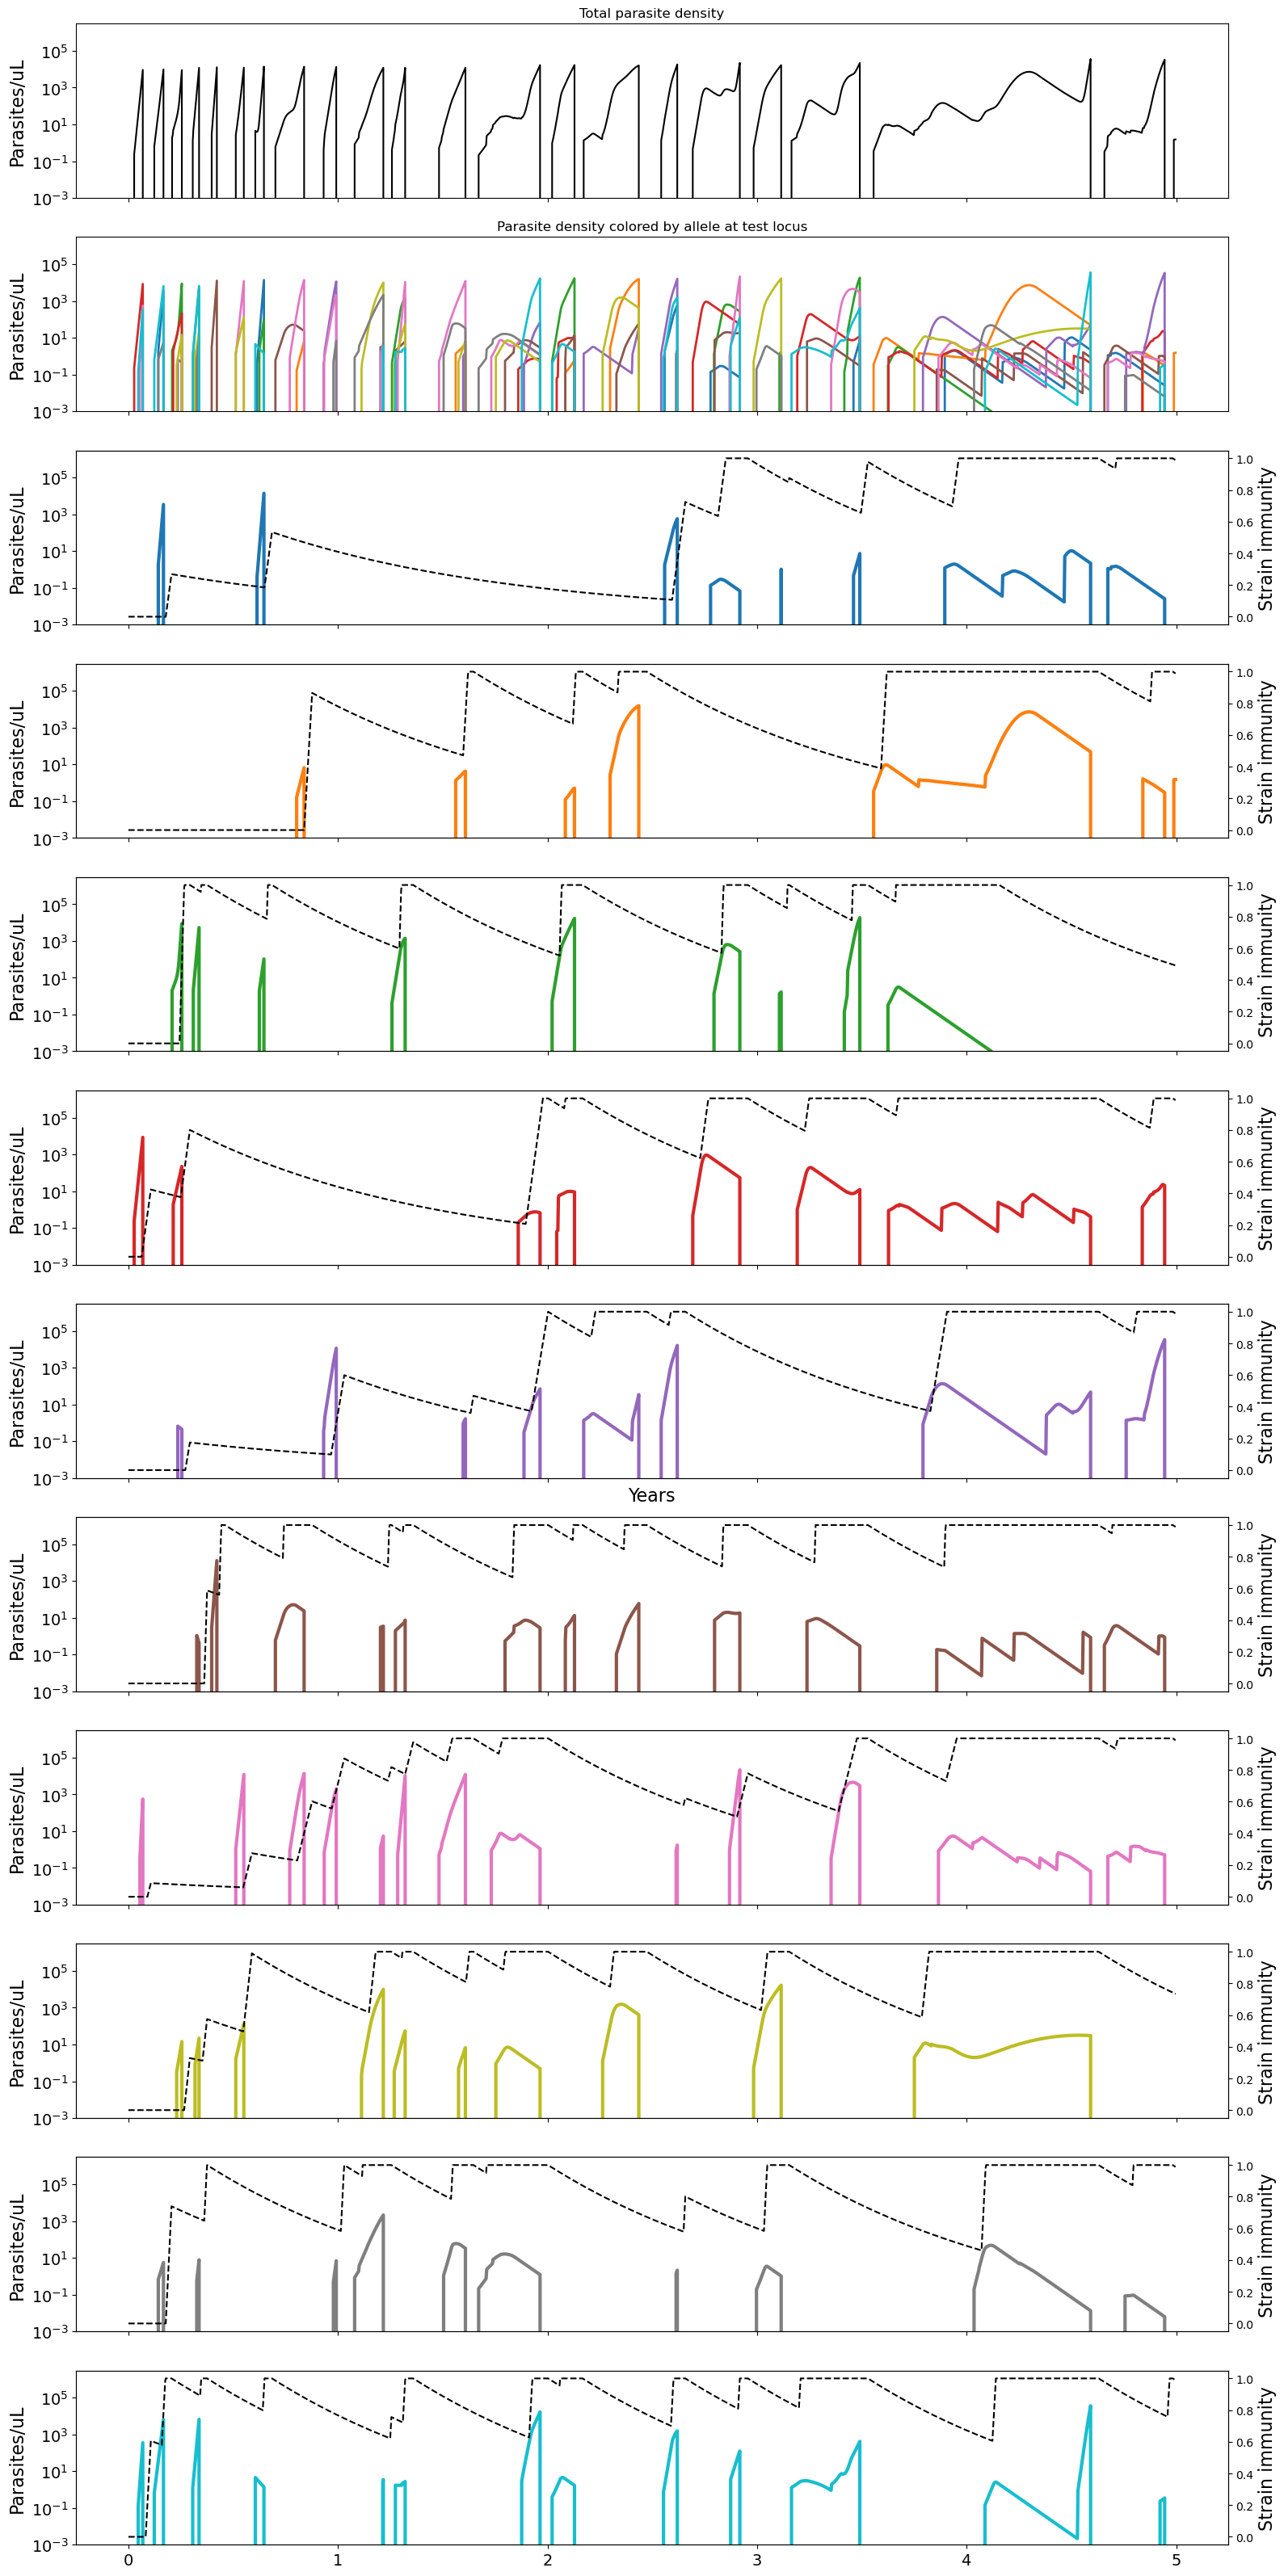

In [23]:
colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple", 5:"tab:brown", 6:"tab:pink",7:"tab:olive",8:"tab:grey",9:"tab:cyan"}

fig, ax = plt.subplots(nrows=12, sharey=True, sharex=True, tight_layout=True, figsize=(16,32))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yscale('log')
ax[0].plot(np.arange(y*365)/365, pmatrix[-1,:,:].sum(axis=0),color="black")
for strain in np.arange(a[-1]):
    iStrain = pmatrix[-1,strain,:]
    if np.sum(iStrain) > 1:
        ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
ax[0].set_ylim(0.001,3000000)
ax[6].set_xlabel('Years',fontsize=16)
ax[0].set_ylabel('Parasites/uL',fontsize=16)
ax[0].set_title('Total parasite density')
ax[1].set_title('Parasite density colored by allele at test locus')
ax[1].set_ylabel('Parasites/uL',fontsize=16)
for row in range(2,12):
    ax[row].tick_params(axis='both', which='major', labelsize=14)
    ax[row].set_ylabel('Parasites/uL',fontsize=16)
    other = [strain for strain in range(0,5) if strain != row-2]
    ax[row].plot(np.arange(y*365)/365, pmatrix[-1,row-2,:],linewidth=3,color=colors[row-2])
    #ax[row].vlines(x=np.asarray(visits)/365,ymin=0.001,ymax=100000,color="black",linestyle="dashed",linewidth=1)

    #for strain in other:
     #   ax[row].plot(np.arange(y*365)/365, all_parasites[i,-1,strain,:],linewidth=2,alpha=0.2,color=colors[strain])

    ax2 = ax[row].twinx()
    ax2.set_ylabel('Strain immunity',fontsize=16)
    ax2.plot(np.arange(y*365)/365, imatrix[-1,row-2,:],linewidth=1.5,color='black',linestyle='dashed')

In [24]:
%lprun -f simulate_person simulate_cohort(n_people,y,eir,a,w)

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_7370/1659544076.py:143: RuntimeWarning: divide by zero encountered in reciprocal
  r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend


Timer unit: 1e-09 s

Total time: 8.81718 s
File: /var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_7370/1659544076.py
Function: simulate_person at line 240

Line #      Hits         Time  Per Hit   % Time  Line Contents
   240                                           def simulate_person(y,eir,a,w,fever_arr,meroz=0.8,growthrate=0.8,mshape=1,rscale=0.4,tHalf=300,rend=-0.05,xh=0.5,b=-1,k=10**6,pgone=0.001,power=1.3,iEffect=0.05,iSkew=2):
   241                                               '''
   242                                               Runs simulation for one person. Returns matrix tracking parasitemia by allele,
   243                                               matrix tracking immunity by allele, matrix tracking parasitemia by strain, and
   244                                               a list containing the days of every malaria episode someone had.
   245                                           
   246                                               Inputs:
 

In [78]:
with open('output/paramsMech.npy', 'rb') as f:
    params = np.load(f)

In [85]:
params[1,:]

array([ 1.29969762e+02,  8.00000000e+00,  4.50000000e+01,  1.26922076e+00,
        5.35464216e-01,  4.84541626e-01,  1.33703508e+00,  1.98537965e+00,
        7.03731875e+02, -2.99661643e-02,  3.66450230e-01,  3.04236204e-01])

In [86]:
a,w = create_weight_alleles(45,8)

In [87]:
all_parasites, all_immunity, all_strains, all_malaria = simulate_cohort(n_people,y,30,a,w,power=1.27,growthrate=0.54,rscale=0.48,meroz=1.3,mshape=1.99,tHalf=704,rend=-0.037,xh=0.37,limm=0.3)

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_7370/1659544076.py:143: RuntimeWarning: divide by zero encountered in reciprocal
  r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend


/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_7370/228172192.py:192: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  return fig.show()


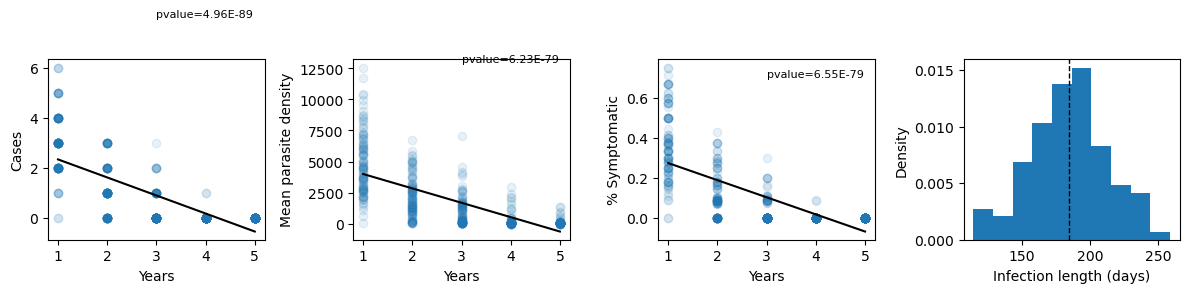

In [88]:
outcomes = run_outcomes(all_parasites,all_strains,all_malaria,y,n_people,n_outcomes)
plot_5years(outcomes)

In [ ]:
i

In [ ]:
growth_rate(0.5,1.4)

In [ ]:
growth_rate(0.95,1.3)

In [ ]:
a = 1 # shape
samples = 1000
s = np.random.power(a, samples)

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, bins=30)
x = np.linspace(0, 1, 100)
y = a*x**(a-1.)
normed_y = samples*np.diff(bins)[0]*y
plt.plot(x, normed_y)
plt.show()

In [ ]:
def check_infection_length(sM,y, malaria):
    lengths = []
    infections = len(sM)
    for i in range(infections):
        counter = 0
        for j in range(y*365):
            if sM[i,j] > 0:
                counter += 1
                if j in malaria:
                    counter = 0
        if counter > 0:
            lengths.append(counter)
    return lengths

In [ ]:
np.sum(np.sign(smatrix),axis=1)

In [ ]:
def get_effect(alpha,median):
    beta = ((3*alpha) - 1 + ((2-(3*alpha))* median))/median
    return np.random.beta(alpha,beta,1000)

In [ ]:
def get_effect(alpha,median):
    beta = ((3*alpha) - 1 + ((2-(3*alpha))* median))/median
    return np.random.beta(alpha,beta,1000)

In [ ]:
def get_effect(alpha,mean):
    beta = (alpha*(1-mean))/mean
    return np.random.beta(alpha,beta,1000)

In [ ]:
size=1000
params = get_effect(1000,0.999)

    
fig,ax = plt.subplots(tight_layout = True)
ax.hist(params,bins=100)
ax.set_ylabel("Count")
ax.set_xlabel("Shape")
print(np.mean(params))